In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.0 MB/s eta 0:00:

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [ ]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 148981643.21it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107580545.14it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36792527.51it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3781367.36it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module): #exemplo simples de um auto encoder, onde o encoder se trata de duas camadas que saem de 784 para 64, e o decoder reverte este processo
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),

            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(

            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  val_loss: 0.196  trn_loss: 0.265  (30.67s - 122.67s remaining)
EPOCH: 2.000  val_loss: 0.173  trn_loss: 0.183  (55.37s - 83.05s remaining)
EPOCH: 3.000  val_loss: 0.162  trn_loss: 0.167  (77.88s - 51.92s remaining)
EPOCH: 4.000  val_loss: 0.156  trn_loss: 0.159  (99.97s - 24.99s remaining)
EPOCH: 5.000  val_loss: 0.152  trn_loss: 0.154  (122.96s - 0.00s remaining)


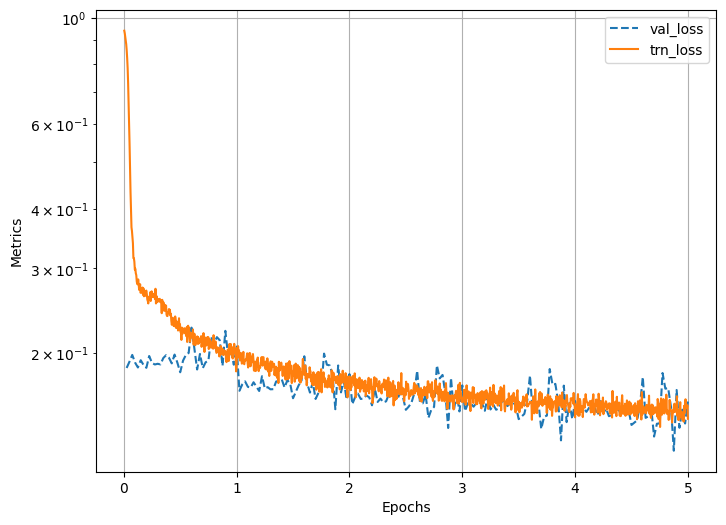

In [ ]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs): #treina o modelo em 5 iterações
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

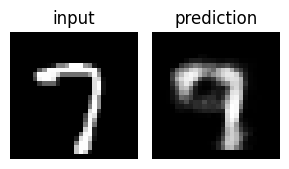

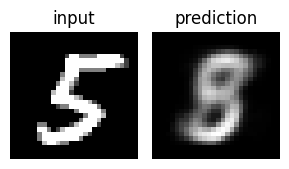

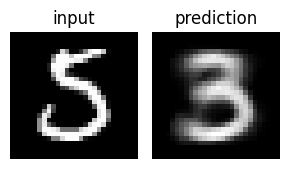

In [ ]:

for _ in range(3): #predições utilizando o modulo 3 de rede neural, com resultados incorreto
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000  val_loss: 0.131  trn_loss: 0.226  (29.69s - 118.78s remaining)
EPOCH: 2.000  val_loss: 0.099  trn_loss: 0.113  (51.64s - 77.46s remaining)
EPOCH: 3.000  val_loss: 0.084  trn_loss: 0.093  (74.08s - 49.39s remaining)
EPOCH: 4.000  val_loss: 0.074  trn_loss: 0.080  (96.70s - 24.18s remaining)
EPOCH: 5.000  val_loss: 0.067  trn_loss: 0.072  (119.98s - 0.00s remaining)


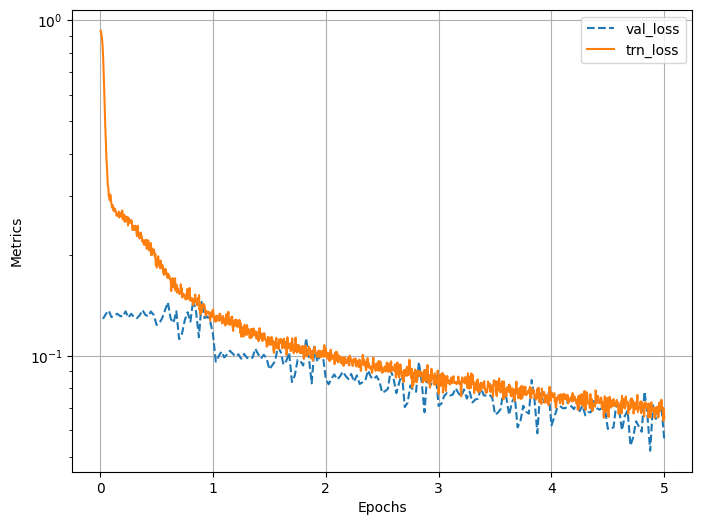

EPOCH: 1.000  val_loss: 0.210  trn_loss: 0.261  (22.78s - 91.12s remaining)
EPOCH: 2.000  val_loss: 0.187  trn_loss: 0.198  (44.84s - 67.26s remaining)
EPOCH: 3.000  val_loss: 0.178  trn_loss: 0.183  (67.46s - 44.97s remaining)
EPOCH: 4.000  val_loss: 0.173  trn_loss: 0.176  (90.08s - 22.52s remaining)
EPOCH: 5.000  val_loss: 0.170  trn_loss: 0.172  (112.96s - 0.00s remaining)


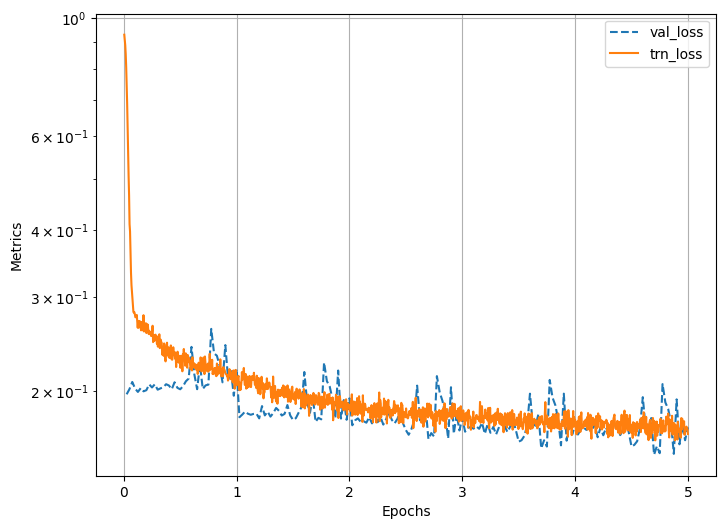

EPOCH: 1.000  val_loss: 0.195  trn_loss: 0.273  (23.02s - 92.06s remaining)
EPOCH: 2.000  val_loss: 0.167  trn_loss: 0.179  (44.93s - 67.40s remaining)
EPOCH: 3.000  val_loss: 0.158  trn_loss: 0.162  (67.52s - 45.02s remaining)
EPOCH: 4.000  val_loss: 0.153  trn_loss: 0.156  (90.34s - 22.58s remaining)
EPOCH: 5.000  val_loss: 0.151  trn_loss: 0.152  (112.88s - 0.00s remaining)


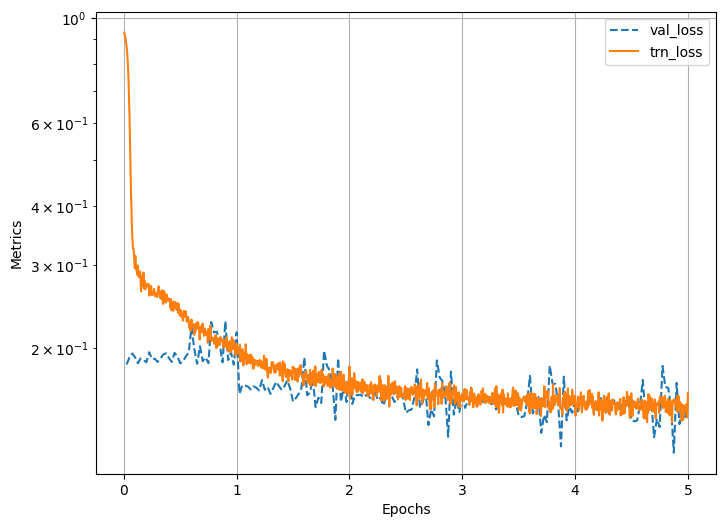

EPOCH: 1.000  val_loss: 0.164  trn_loss: 0.253  (22.09s - 88.34s remaining)
EPOCH: 2.000  val_loss: 0.138  trn_loss: 0.148  (45.05s - 67.57s remaining)
EPOCH: 3.000  val_loss: 0.128  trn_loss: 0.133  (67.73s - 45.15s remaining)
EPOCH: 4.000  val_loss: 0.122  trn_loss: 0.126  (90.50s - 22.63s remaining)
EPOCH: 5.000  val_loss: 0.119  trn_loss: 0.121  (112.51s - 0.00s remaining)


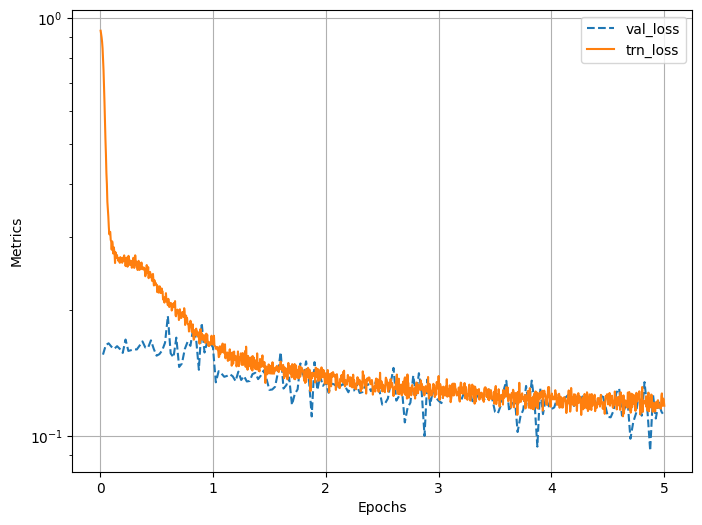

EPOCH: 1.000  val_loss: 0.156  trn_loss: 0.249  (22.67s - 90.66s remaining)
EPOCH: 2.000  val_loss: 0.116  trn_loss: 0.132  (45.20s - 67.80s remaining)
EPOCH: 3.000  val_loss: 0.101  trn_loss: 0.109  (67.96s - 45.30s remaining)
EPOCH: 4.000  val_loss: 0.094  trn_loss: 0.099  (90.97s - 22.74s remaining)
EPOCH: 5.000  val_loss: 0.089  trn_loss: 0.093  (112.94s - 0.00s remaining)


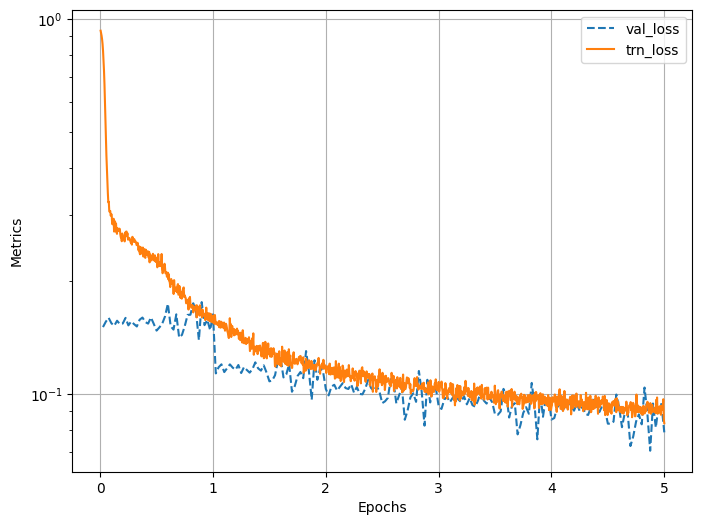

In [ ]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

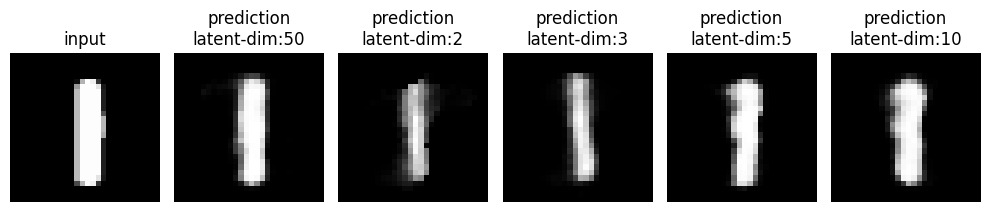

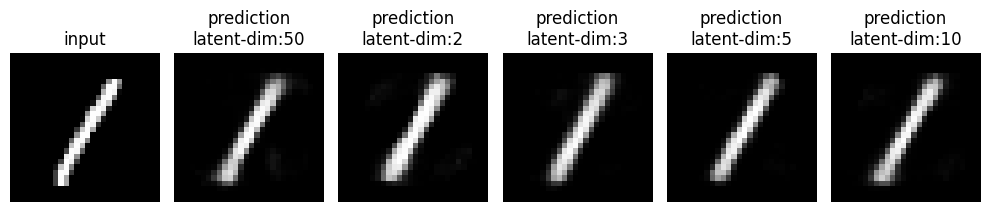

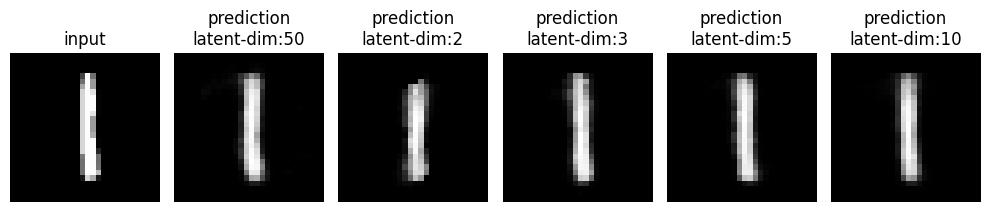

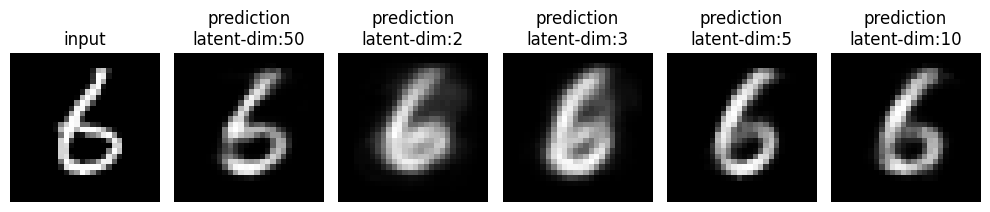

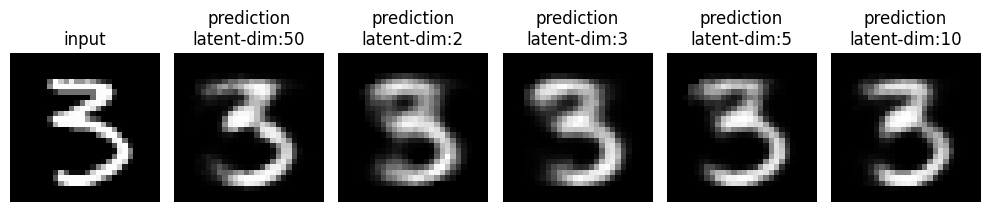

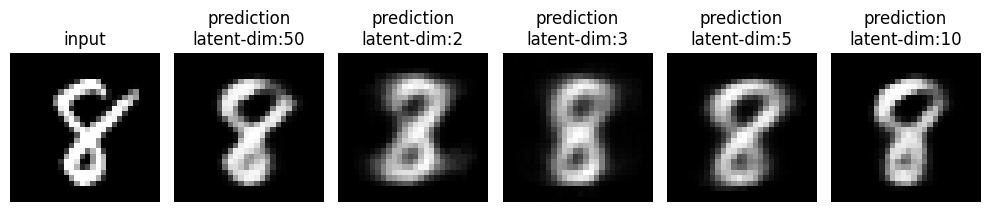

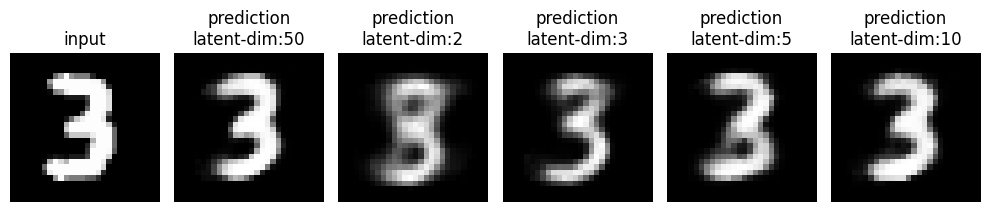

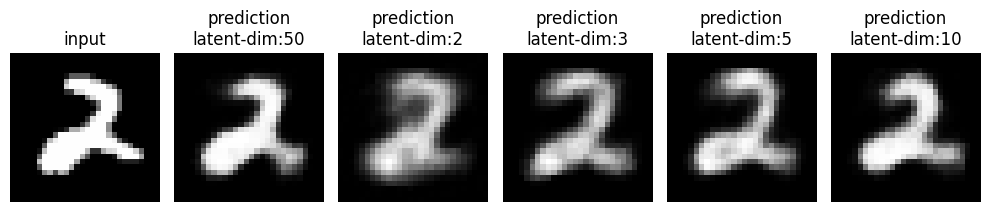

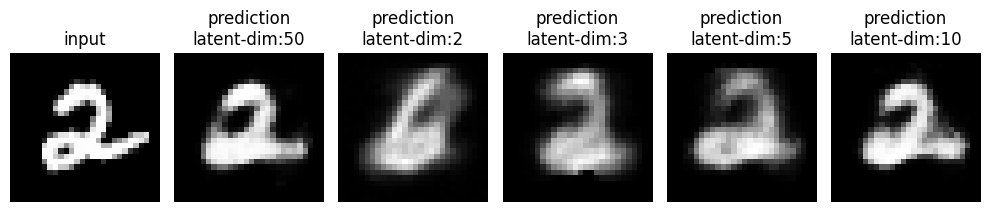

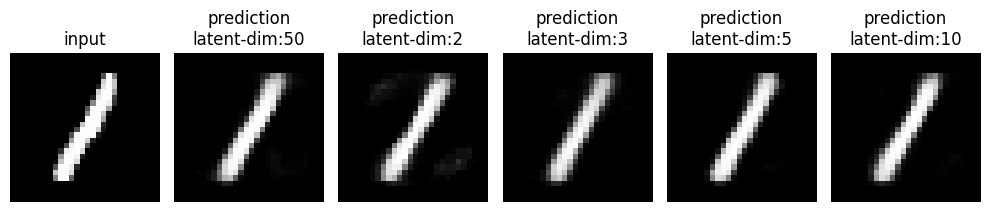

In [ ]:
for _ in range(10): #predições utilizando o modulo da rede neural semelhante a dimensão latente, produzindo resultados condizentes com a entrada
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()